<a href="https://colab.research.google.com/github/arn97/MLTSA25_ARoy/blob/main/MLTSA_ARoy/HW5_ARoy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
!pip install ruptures
import ruptures as rpt
import pylab as pl
import pandas as pd
import numpy as np
%pylab inline




Populating the interactive namespace from numpy and matplotlib


# Synthetic data
the cell below creates a synthetic dataset _(x,y)_ of 200 points, generated by two processes $ y =c + \epsilon$ with $\epsilon \sim N(0,1)$ (Gaussian stationary processes) that generate 100 points each with means 20 and 25 respectively.

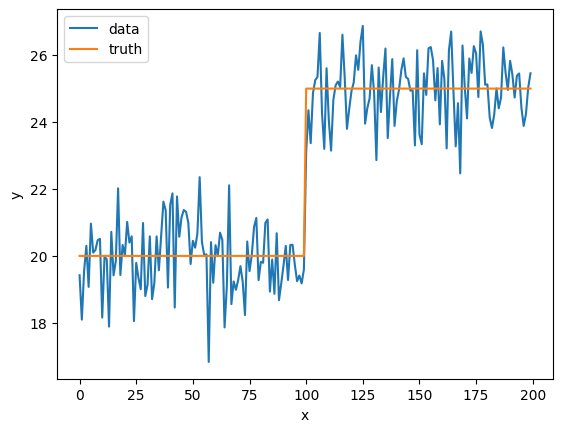

In [89]:
mu1, mu2 = 20, 25
x = np.arange(200)
ym = np.concatenate([np.random.randn(100) + mu1, np.random.randn(100) + mu2])
pl.plot(x, ym, label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, label="truth")
pl.xlabel("x")
pl.ylabel("y")
pl.legend();

# Single POC -  difference of means
write a function that finds the POC by assuming a single POC and maximizing the differencem in the means before and after the POC as described in
https://slides.com/federicabianco/mltsa4#/6/1
test it on the synthetic dataset _(x,y)_

In [90]:
def maxdiff(y):
    """calculates the POC as the points that maximized the difference between the mean before and the mean after the POC
    y: vector of endogenouos variables

    """
    N = len(y)
    f = np.nanmean
    poc, diff, before, after = 0, 0, np.nan, np.nan
    for i in range(1, N):
        diff_here = np.abs(f(y[i:]) -  f(y[:i]))
        if diff < diff_here:
            diff = diff_here
            poc = i
            before, after = f(ym[:i]), f(ym[i:])
    return(poc, before, after)

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*maxdiff(ym)))


poc: 100.00, mean before: 19.94, mean after: 24.97


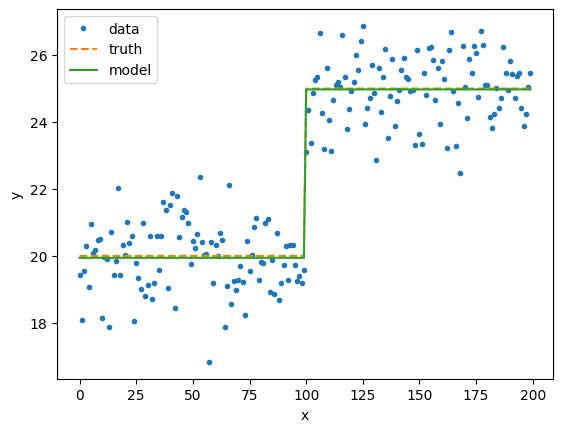

In [91]:
poc, before, after = maxdiff(ym)
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

Plot of prediction by the maxdiff function for mu1, mu2 and the point of change for the ym dataset against the true values and true average. The function has predicted the averages with very high accuracy and the POC with perfect accuracy.

# Single POC - MSE
write a function that finds the POC by minimizing the square error (see slide https://slides.com/federicabianco/mltsa4#/6/2) a single POC and maximizing the differencem in the means before and after the POC. like before return the index of the POC, the mean before and the mean after the POC.
Plot the data, the model, the truth, like in the step above.


Remember to write a docstring for the function https://www.python.org/dev/peps/pep-0257/!

In [92]:
def poc_mse(y):
    """Calculates the POC by minimizing the mean squared error (MSE)
       assuming a single POC and maximizing the difference in means before and after the POC.

    Args:
        y: A vector of endogenous variables.

    Returns:
        A tuple containing the index of the POC, the mean before the POC,
        and the mean after the POC.
    """
    N = len(y)
    mse, poc, before, after = float('inf'), 0, np.nan, np.nan
    for i in range(1, N):
        before_mean = np.mean(y[:i])
        after_mean = np.mean(y[i:])
        mse_here = np.sum((y[:i] - before_mean)**2) + np.sum((y[i:] - after_mean)**2)
        diff_here = np.abs(after_mean - before_mean)
        if mse > mse_here and diff_here > 0:  # Check for improvement in MSE and non-zero difference
            mse = mse_here
            poc = i
            before, after = before_mean, after_mean
    return poc, before, after


poc, before, after = poc_mse(ym)

In [93]:
print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*poc_mse(ym)))


poc: 100.00, mean before: 19.94, mean after: 24.97


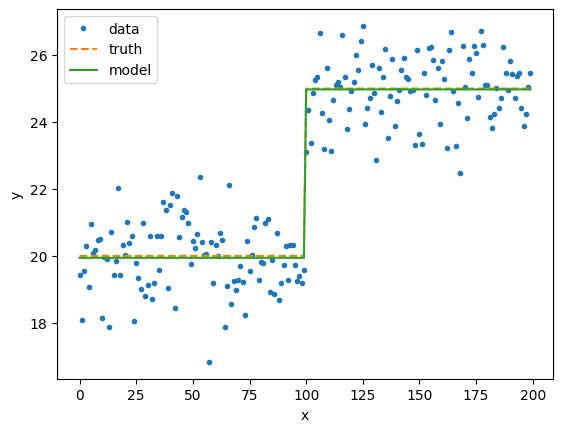

In [94]:
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

Plot of prediction by the maxdiff function for mu1, mu2 and the point of change for the ym dataset against the true values and true average. The function has predicted the averages with very high accuracy and the POC with perfect accuracy. The prediction by poc_mse is almost same as the prediction by maxdiff.

# Single POC - diff of variance
Generate a new synthetic dataset _(x,ys)_ of 200 points, generated by two processes $ y =c + \epsilon$ with $\epsilon \sim N(\sigma,1)$ (Gaussian stationary processes) that generate 100 points each with means 20 and variance 1 and 4 respectively.

Modify the ```maxdiff()``` function so that it take an optional parameter sigma which allows you to use the function to choose the POC that maximizes the different in standard deviation, instead of in mean. An optional argument is an argument that is set to a default in the function call. The default behavior of the function shoudl still be to calculate the POC as the point that maximized the before and after difference in the _mean_.


In [95]:
mu1, mu2 = 20, 25
s2 = 4
ys = np.concatenate([np.random.randn(100)  + mu1 , np.random.randn(100) * s2 + mu1])

In [96]:
def maxdiff(y, sigma=False):
    """calculates the POC as the points that maximized the difference between
                the mean or variance before and the mean after the POC
    y: vector of endogenouos variables
    sigma: finds the POC that maximizes the difference between before/after POC variance
                (optional, default is before/after mean)
    """

    N = len(y)
    if sigma:
        f = np.nanstd
    else:
        f = np.nanmean
    poc, diff, before, after = 0, 0, np.nan, np.nan
    for i in range(1, N):
        diff_here = np.abs(f(y[i:]) - f(y[:i]))
        if diff < diff_here:
            diff = diff_here
            poc = i
            before, after = f(y[:i]), f(y[i:])
    return(poc, before, after)

print("poc: {:.2f}, std before: {:.2f}, std after: {:.2f}".format(*maxdiff(ys,
                                                                    sigma=True)))


poc: 100.00, std before: 0.99, std after: 4.29


In [97]:
...

Ellipsis

# Find POC with rupture python package.
install and import the rupture package.
Find the POC in each synthetic time series.
Use the Pelt method. Reflect on the parameters that should be passed to the predict() function. Read the manual and feel free to ask questions on slack.

In [98]:
rpt.Pelt.predict?

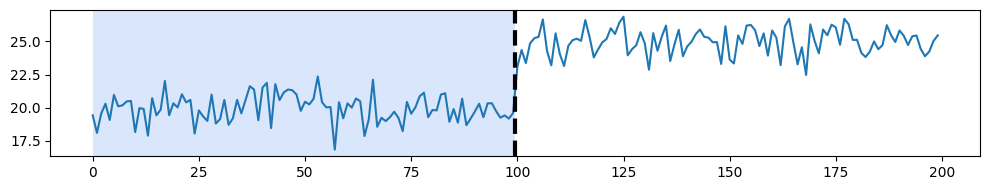

In [99]:
# detection
algo = rpt.Pelt(model='l2').fit(ym)
result = algo.predict(pen=10)

# display
rpt.display(ym, [100], result)
pl.show()

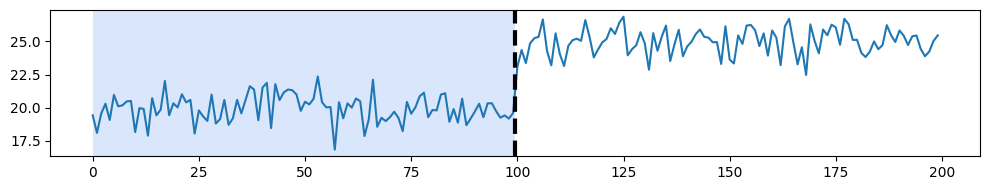

In [100]:
# detection
algo = rpt.Pelt(model='l1').fit(ym)
result = algo.predict(pen=10)

# display
rpt.display(ym, [100], result)
pl.show()

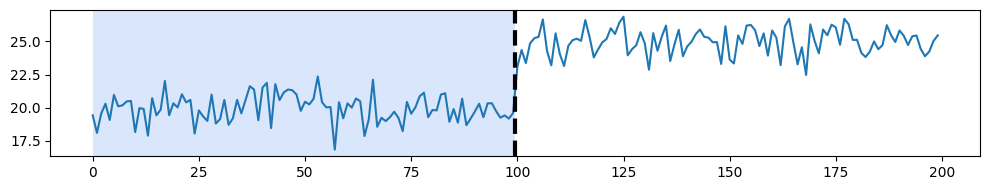

In [101]:
# detection
algo = rpt.Pelt(model='rbf').fit(ym)
result = algo.predict(pen=10)

# display
rpt.display(ym, [100], result)
pl.show()

/usr/local/lib/python3.11/dist-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


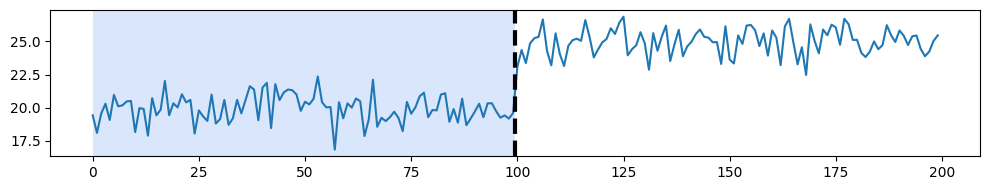

In [102]:
# detection
algo = rpt.Pelt(model='normal').fit(ym)
result = algo.predict(pen=20)

# display
rpt.display(ym, [100], result)
pl.show()

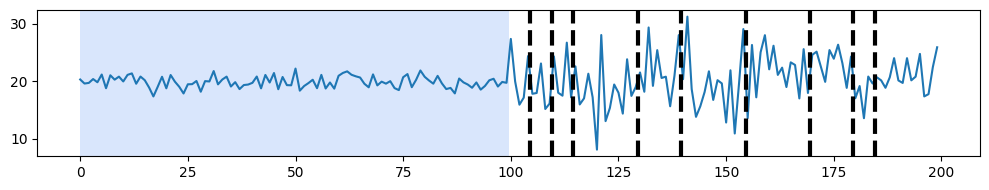

In [103]:
# detection
algo = rpt.Pelt(model='l2').fit(ys)
result = algo.predict(pen=10)

# display
rpt.display(ys, [100], result)
pl.show()

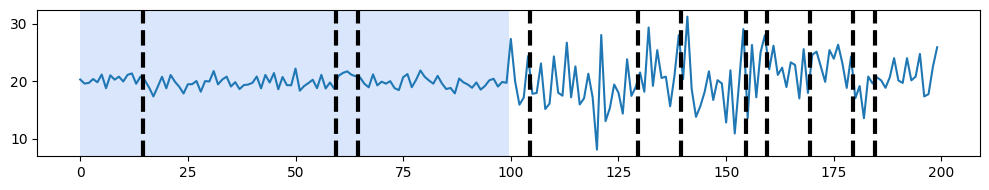

In [104]:
# detection
algo = rpt.Pelt(model='l1').fit(ys)
result = algo.predict(pen=2)

# display
rpt.display(ys, [100], result)
pl.show()

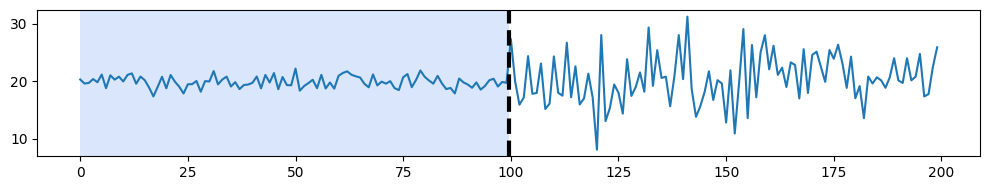

In [105]:
# detection
algo = rpt.Pelt(model='rbf').fit(ys)
result = algo.predict(pen=10)

# display
rpt.display(ys, [100], result)
pl.show()

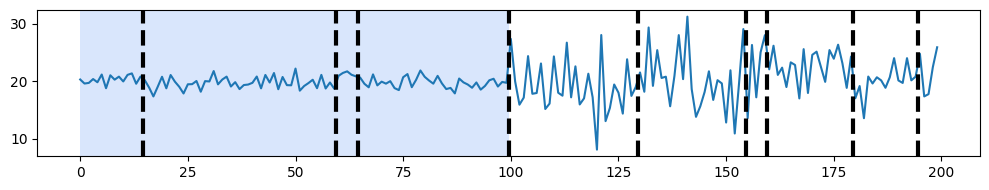

In [106]:
# detection
algo = rpt.Pelt(model='rbf').fit(ys)
result = algo.predict(pen=1)

# display
rpt.display(ys, [100], result)
pl.show()

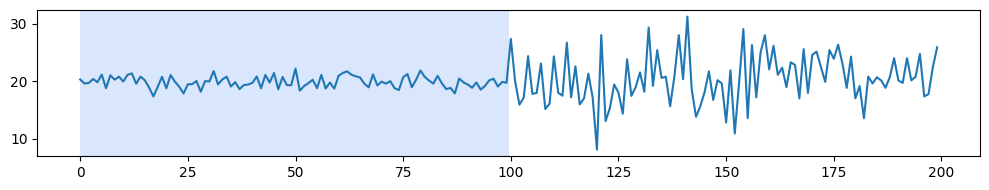

In [107]:
# detection
algo = rpt.Pelt(model='rbf').fit(ys)
result = algo.predict(pen=100)

# display
rpt.display(ys, [100], result)
pl.show()

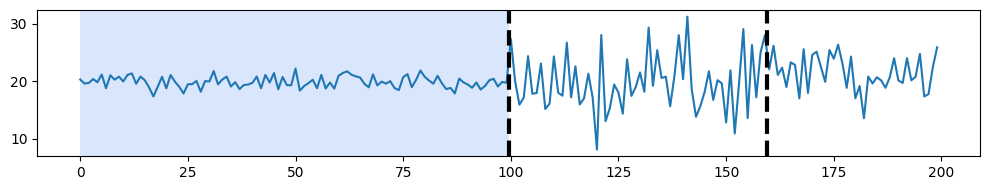

In [108]:
# detection
algo = rpt.Pelt(model='normal').fit(ys)
result = algo.predict(pen=10)

# display
rpt.display(ys, [100], result)
pl.show()

##Reflection on parameters for predict() function:##
pen: The penalty value controls the number of change points detected. A higher penalty leads to fewer change points, while a lower penalty leads to more change points. Hence we need to choose a penalty value that is not too large to detect the true POC and also not too small to detect some noise in the data as POC. For example when we are trying to identify the POC at t = 100 for the ys time series using the 'rbf' model we see that when pen=10 the algorithm is detecting the POC accurately and not detecting any false POC. When pen=1 the algorithm is detecting several more false POCs in addition to the actual POC. And finally pen=100 the algorithm fails to detect even the true POC.

# read in the data from LANL earthquake prediction
I saved in the github repo as "http://fbb.space/mltsa/LALNeq.csv. This is a large file and will take a long time to read in. It is 1/100th of the original file. See how nice I am!?! https://www.kaggle.com/c/LANL-Earthquake-Prediction/data

Visualize and use the method DataFrame.describe() to extract some basic statistics of the dataset

In [109]:
eq1 ...
eq1.describe()

SyntaxError: invalid syntax (<ipython-input-109-108369bb54a9>, line 1)

In [ ]:
eq1.head()

# using rupture

Go through the documentation of rupture.

Find a method that takes as input the number of pocs and has computational complexity O(kN^2) and run it for k=1,2,3 pocs on the first N=10,000, 5000, and 1000 rows of the datasets respectively (make a plot for each and discuss each in the caption)




In [ ]:
algo1 = rpt....
result = algo1.predict(n_bkps=1)

# display
rpt.display(eq1.acoustic_data.values[:10000], [], result)
plt.show()


caption

In [ ]:
algo2 = ...

In [ ]:
algo3 = rpt....

Find a method that has computational complexity O(Nlog(N))

Run both methods on the full 10000 rows dataset with the goal is to isolate 3 chunks of the time series. Read about the methods you choose, and describe the constraints you imposed and the paraemters you choose.

In [ ]:
algo = ...

caption (note that your plot does not need to look exactly like mine